In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Emissions

In [12]:
df_emissions = pd.read_csv("./Data/emisssions.csv")
df_emissions.head()

,city,date,sector,value,timestamp
0,Canberra,01/01/2019,Aviation,0.026581,1546300800
1,Canberra,02/01/2019,Aviation,0.028275,1546387200
2,Canberra,03/01/2019,Aviation,0.028120,1546473600
3,Canberra,04/01/2019,Aviation,0.028199,1546560000
4,Canberra,05/01/2019,Aviation,0.028428,1546646400


In [33]:
df_NYground_emissions = df_emissions[(df_emissions['city'] == "New York (Greater)") & 
                                     (df_emissions['sector'] == "Ground Transport")].copy()
df_NYground_emissions['date'] = pd.to_datetime(df_NYground_emissions['date'], format='%d/%m/%Y')
df_NYground_emissions['year'] = df_NYground_emissions['date'].dt.year
df_NYground_emissions[df_NYground_emissions['year'] == 2022]

,city,date,sector,value,timestamp,year
342630,New York (Greater),2022-01-01,Ground Transport,32.7337,1640995200,2022
342631,New York (Greater),2022-01-02,Ground Transport,37.4142,1641081600,2022
342632,New York (Greater),2022-01-03,Ground Transport,35.3106,1641168000,2022
342633,New York (Greater),2022-01-04,Ground Transport,36.3643,1641254400,2022
342634,New York (Greater),2022-01-05,Ground Transport,38.2897,1641340800,2022
...,...,...,...,...,...,...
342990,New York (Greater),2022-12-27,Ground Transport,31.3634,1672099200,2022
342991,New York (Greater),2022-12-28,Ground Transport,37.1109,1672185600,2022
342992,New York (Greater),2022-12-29,Ground Transport,37.2068,1672272000,2022
342993,New York (Greater),2022-12-30,Ground Transport,38.0135,1672358400,2022


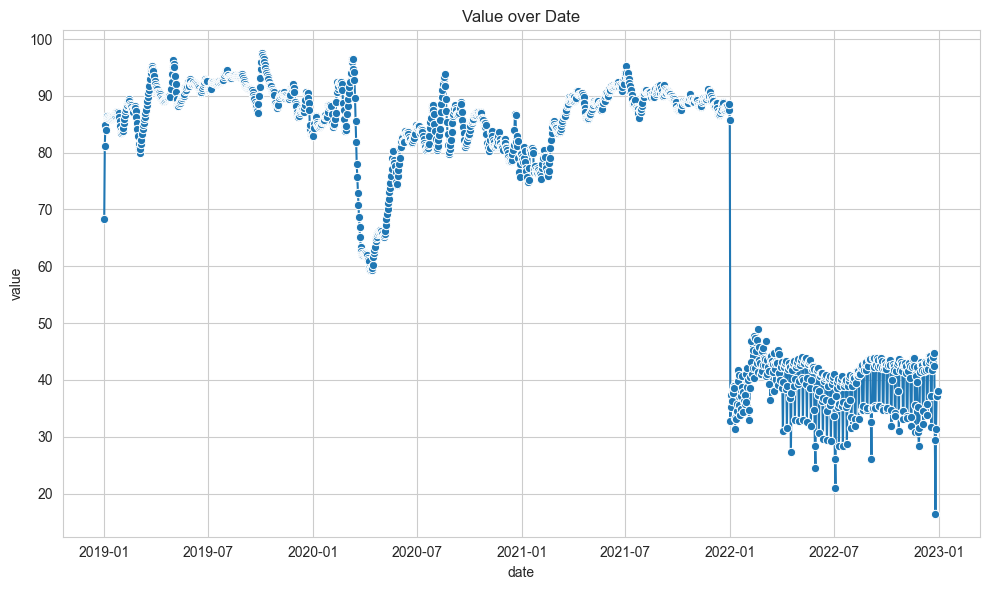

In [30]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(x='date', y='value', data=df_NYground_emissions, marker='o')
plt.title('Value over Date')
plt.tight_layout()
plt.show()

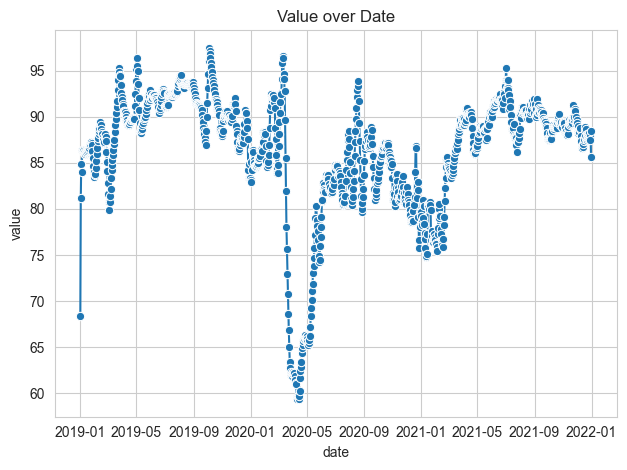

In [35]:
df_NYground_emissions = df_NYground_emissions[df_NYground_emissions['year'] != 2022]
sns.lineplot(x='date', y='value', data=df_NYground_emissions, marker='o')
plt.title('Value over Date')
plt.tight_layout()
plt.show()

## Bikes

In [36]:
import os

dfs = []

folder_path = './Data/CitiBike 2020/'
all_files = os.listdir(folder_path)
for file in all_files:
    file_path = os.path.join(folder_path, file)
    dfs.append(pd.read_csv(file_path))

folder_path = './Data/CitiBike 2021/'
all_files = os.listdir(folder_path)
for file in all_files:
    file_path = os.path.join(folder_path, file)
    dfs.append(pd.read_csv(file_path))

df_bike = pd.concat(dfs, ignore_index=True)
df_bike.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,146,2020-12-01 00:02:50.1450,2020-12-01 00:05:16.1940,3202,Newport PATH,40.727224,-74.033759,3199,Newport Pkwy,40.728745,-74.032108,42308,Subscriber,1989,2
1,572,2020-12-01 00:11:57.3910,2020-12-01 00:21:30.2510,3640,Journal Square,40.733670,-74.062500,3280,Astor Place,40.719282,-74.071262,18568,Subscriber,1997,2
2,387,2020-12-01 00:14:49.3610,2020-12-01 00:21:16.8730,3640,Journal Square,40.733670,-74.062500,3194,McGinley Square,40.725340,-74.067622,44543,Subscriber,1960,1
3,188,2020-12-01 00:45:06.3680,2020-12-01 00:48:14.4280,3186,Grove St PATH,40.719586,-74.043117,3270,Jersey & 6th St,40.725289,-74.045572,43098,Subscriber,1998,1
4,594,2020-12-01 01:17:17.0110,2020-12-01 01:27:11.9400,3212,Christ Hospital,40.734786,-74.050444,3209,Brunswick St,40.724176,-74.050656,44723,Subscriber,1988,1


## Uber

In [7]:
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import folium
import plotly.express as px
from datetime import time
from PIL import Image
from time import perf_counter
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression,Lasso,LassoCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import DBSCAN
from xgboost import XGBRegressor
from folium.plugins import HeatMap, HeatMapWithTime

## migic functions
%matplotlib inline

# auxiliary functions
## data processing methods
def check_missing_val(data):
    print("Checking attributes that have missing values...")
    for col in data.columns:
        if data[col].isnull().sum() !=0:
            print("{} : {}".format(col,data[col].isnull().sum()))

def check_uniqueness(data):
    print("Checking uniqueness of each attributes ...")
    for col in data.columns:
        print("{} : {} -> {}".format(col,data[col].is_unique,len(data[col].unique())))
        
def get_quantile(data,col_name,q_val,inter):
    return np.percentile(data[col_name],q_val,method=inter)

def iqr_test(data,col_name,inter):
    qu = get_quantile(data,'quantity',75,inter)
    ql = get_quantile(data,'quantity',25,inter)
    diff = qu - ql
    U = qu + 1.5 * diff
    L = ql - 1.5 * diff
    return U,L

def remove_outliers(data,col_name,inter):
    """filter the outliers of the numerical data

    Args:
        data (_type_): _description_
        col_name (_type_): _description_
        inter (_type_): _description_

    Returns:
        _type_: _description_
    """
    U,L = iqr_test(data,col_name,inter)
    return data[data[col_name]>= L | data[col_name]<=U]
    
        
def get_kmeans_categories(centroid,centers):
    """Returns the correct class when centroid is given

    Args:
        centroid (float): centroid assigned to given order
        centers (float): all centroids given by KNN

    Returns:
        str: specified distance range
    """
    if centroid == centers[0]:
        return 'short_range'
    elif centroid == centers[1]:
        return 'mid_range'
    else:
        return 'long_range'
    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """This function prints and plots the confusion matrix. 
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
fhvhv_tripdata_2021_01 = pq.read_table('./Data/Uber/fhvhv_tripdata_2021-01.parquet')
fhvhv_tripdata_2021_01 = fhvhv_tripdata_2021_01.to_pandas()
fhvhv_tripdata_2021_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11908468 entries, 0 to 11908467
Data columns (total 24 columns):
 #   Column                Dtype         
---  ------                -----         
 0   hvfhs_license_num     object        
 1   dispatching_base_num  object        
 2   originating_base_num  object        
 3   request_datetime      datetime64[ns]
 4   on_scene_datetime     datetime64[ns]
 5   pickup_datetime       datetime64[ns]
 6   dropoff_datetime      datetime64[ns]
 7   PULocationID          int64         
 8   DOLocationID          int64         
 9   trip_miles            float64       
 10  trip_time             int64         
 11  base_passenger_fare   float64       
 12  tolls                 float64       
 13  bcf                   float64       
 14  sales_tax             float64       
 15  congestion_surcharge  float64       
 16  airport_fee           float64       
 17  tips                  float64       
 18  driver_pay            float64       
 19

In [9]:
fhvhv_tripdata_2021_01['shared_request_flag'] = fhvhv_tripdata_2021_01['shared_request_flag'].apply(lambda x: 1 if x == 'Y' else 0)
fhvhv_tripdata_2021_01['shared_match_flag'] = fhvhv_tripdata_2021_01['shared_match_flag'].apply(lambda x: 1 if x == 'Y' else 0)
fhvhv_tripdata_2021_01['access_a_ride_flag'] = fhvhv_tripdata_2021_01['access_a_ride_flag'].apply(lambda x: 1 if x == 'Y' else 0)
fhvhv_tripdata_2021_01['wav_request_flag'] = fhvhv_tripdata_2021_01['wav_request_flag'].apply(lambda x: 1 if x == 'Y' else 0)
fhvhv_tripdata_2021_01['wav_match_flag'] = fhvhv_tripdata_2021_01['wav_match_flag'].apply(lambda x: 1 if x == 'Y' else 0)

In [ ]:
fhvhv_tripdata_2021_01.loc[fhvhv_tripdata_2021_01.PULocationID.isin(airport_ids) & fhvhv_tripdata_2021_01.DOLocationID.isin(airport_ids),'airport_fee'] = 6852*[5]
fhvhv_tripdata_2021_01.loc[fhvhv_tripdata_2021_01.PULocationID.isin(airport_ids) & ~fhvhv_tripdata_2021_01.DOLocationID.isin(airport_ids),'airport_fee'] = 168695*[2.5]
fhvhv_tripdata_2021_01.loc[~fhvhv_tripdata_2021_01.PULocationID.isin(airport_ids) & fhvhv_tripdata_2021_01.DOLocationID.isin(airport_ids),'airport_fee'] = 190456*[2.5]